# Sentiment Analysis and the Shapes of Stories 

When I accidentally stumbled upon a presentation from [Kurt Vonnegut](https://en.wikipedia.org/wiki/Kurt_Vonnegut) on how [stories have a shape](https://www.youtube.com/watch?v=GOGru_4z1Vc) I started thinking... "Would you be able to use natural language processing (NLP) to pick up these shapes based on sentiment analysis of the paragraphs?" So here I'll show you the approach I came up with, and the application on [J.R.R. Tolkien](https://en.wikipedia.org/wiki/J._R._R._Tolkien)'s [Lord of the Rings](https://en.wikipedia.org/wiki/The_Lord_of_the_Rings).


To run this notebook I recomment installing **Anaconda**, it comes with all required packages included.


## Sentiment Analysis in Python

Python has the [Natural Language Toolkit](https://www.nltk.org/) which includes a very easy way to do sentiment analysis. Import the correct library, create a SentimentIntsenityAnalyzer() and apply it on a fragment of text. Done! Just look at the examples below how a few lines of code can pick up which fragments are positive, negative or neutral (reflected in the 'pos', 'neg', 'neu'). Furthermore there is a **compound score** that is positive if the overall sentiment of the text is good and negative if it is bad, this is the metric we want to create the shape of the story.

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [2]:
print(sid.polarity_scores("He smiled, he was happy. It had been an amazing day!"))
# {'compound': 0.906, 'neg': 0.0, 'neu': 0.415, 'pos': 0.585}
print(sid.polarity_scores("They feared the others. When they show up, bad things happen."))
# {'neg': 0.427, 'neu': 0.573, 'pos': 0.0, 'compound': -0.7717}
print(sid.polarity_scores("While driving to their destination, nothing happened."))
# {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

{'neg': 0.0, 'neu': 0.415, 'pos': 0.585, 'compound': 0.906}
{'neg': 0.427, 'neu': 0.573, 'pos': 0.0, 'compound': -0.7717}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


## Parsing your book

You'll have to go over your book and extract the paragraphs. Titles, subtitles, ... will need to be removed. Specifically for Lord of the Rings - The Fellowship of the Ring dialog and songs were removed as well. Only paragraphs of sufficient length are stored. So in total we are only considering the 303 longest paragraphs in this book for the analysis. 

I stored the parsed book to a .json file like this:

```json
[
  { "paragraph" : "Paragraph one text..." },
  { "paragraph" : "Paragraph two text..." },
  ...
]
```

As LotR is protected by copyright. I have both a physical as a digital copy legally, though I can't share the parsed book here.

Using the code below, this file can be loaded and the sentiment analysis applied to each paragraph. Scores are stored into a pandas dataframe. As sentiment analysis can be rather noisy and one paragraph can be very positive, followed by a rather negative one, however a few negative ones in a row are relevant. Therefore a rolling window will be applied to the scores to get the average score over a number of paragraphs.

In [3]:
# Only execute this cell if you have a JSON file with your paragraphs, as LotR is not free this file cannot be included in the
# repository. However, this part is essential to show how the sentiment anlysis is done.

import json
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

data = []
with open('./output/The_Fellowship_Of_The_Ring.paragraphs.json', 'r') as fin:
    data = json.load(fin)

    
df = pd.DataFrame([sid.polarity_scores(p['paragraph']) for p in data])
df.to_csv('The_Fellowship_Of_The_Ring.scores.csv')
df.head()


,compound,neg,neu,pos
0,0.9676,0.048,0.782,0.170
1,0.9384,0.069,0.783,0.148
2,0.9645,0.070,0.845,0.086
3,0.7550,0.050,0.891,0.059
4,0.9870,0.025,0.775,0.200


In [ ]:
# In case you want to follow along with this notebook, skip the previous cell and load this one instead. Here it will load all
# sentiment scores for The fellowship of the ring

import json
import pandas as pd

df = pd.read_csv('The_Fellowship_Of_The_Ring.scores.csv')


In [4]:
# Create a column with paragraph numbers (starting with 1)
df['paragraph_num'] = df.index + 1

# Apply a rolling window on the compound and zlog score to smooth out noise
# Downside is that the first and last elements will be NA
df['smooth_compound'] = df['compound'].rolling(window=20, center=True, win_type='triang').mean()
df.head()

,compound,neg,neu,pos,paragraph_num,smooth_compound
0,0.9676,0.048,0.782,0.170,1,NaN
1,0.9384,0.069,0.783,0.148,2,NaN
2,0.9645,0.070,0.845,0.086,3,NaN
3,0.7550,0.050,0.891,0.059,4,NaN
4,0.9870,0.025,0.775,0.200,5,NaN


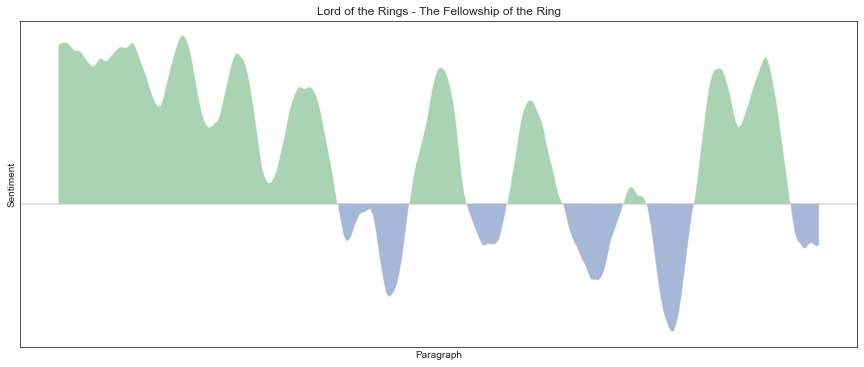

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]

blue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
green = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

sns.set_style("white")
plt.title('Lord of the Rings - The Fellowship of the Ring')
plt.xlabel('Paragraph')
plt.ylabel('Sentiment')
plt.xticks([])
plt.yticks([])

plt.fill_between(df.paragraph_num, 0, df.smooth_compound, alpha=0.5, where=df.smooth_compound >= 0, facecolor=green, interpolate=True)
plt.fill_between(df.paragraph_num, 0, df.smooth_compound, alpha=0.5, where=df.smooth_compound < 0, facecolor=blue, interpolate=True)

plt.axhline(linewidth=1.5, c='gray', alpha=0.3)

with open('Fellowship.svg','wb') as svg_out:
    plt.savefig(svg_out, format="svg")

plt.show()

## The shape of Lord of the Rings - The fellowship of the Ring

**Spoiler alert** the next paragraph contains rather explicit spoilers about both the book and the movie. If you don't want either to be spoiled stop reading here.

As you can see the story oscilates between positive and negative parts, one of the shapes Kurt Vonnegut describes albeit repeated several times. Lets zoom into some sections to see if this makes sense.

### Paragraph 1-114

Tolkien is known for his eye for detail which often results in lengthy descriptions of locations, characters and history. The book starts with Bilbo's 111th birthday celebrations and introduces the Shire (where the Hobbits live), their habits and homes in great detail. 

### Paragraph 115-148

In the book as in the movie this is the first part that is really quite grim and dark. The black-riders (ring-wraiths) arrive in Bree where the Hobbits just met Aragon, causing mayham in the village. Next, the Hobbits and Aragon flee but end up facing the nine Riders on Weathertop, Frodo gets injured badly and they have to hurry to Rivendell. 

### Paragraph 149-159

The fellowship is safe in Rivendell. 

### Paragraph 160-198

Here a lot of the history of Sauron is unveiled, also the story of Gandalf and Saruman is presented and Gollum is interoduced. All of this leads up to the creation of the Fellowship of the Ring and their departure from Rivendell.

### Paragraph 199-210

The fellowship is on the road, at first their journey is fine but as the approas Caradhras the run into problems and decide to take a more perilous path through the Mines of Moria.

### Paragraph 211-250

The fellowship enters the Mines and ultimately encounters the Balrog. Gandalf falls into the abyss after shoutig "Fly, you fools" and is presumed dead. The others escape the Mines with their lives.

### Paragraph 250-290

Lothlórien, the fellowship enters the forest and meets Galadriel the Lady of Lórien. They have time to find their strength again and leave with fresh supplies and gear.


### Paragraph 290-303

Boromir betrays the fellowship and attempts to get the ring. As a consequence Frodo takes off with Sam breaking up the fellowship.

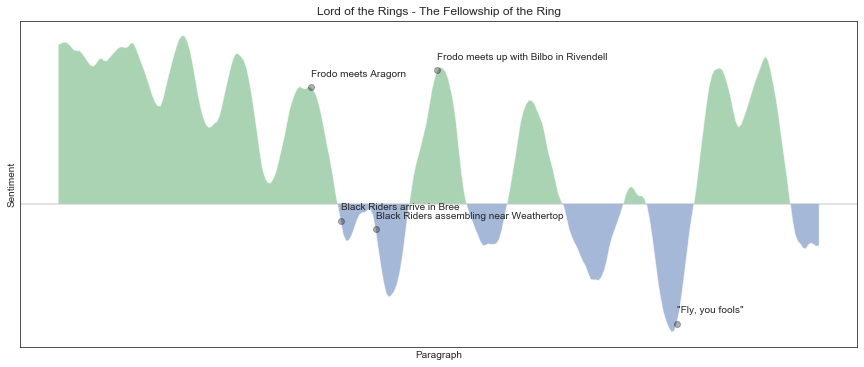

In [7]:
annotations = [
    ('Frodo meets Aragorn', (105, df.iloc[104]['smooth_compound'])),
    ('Black Riders arrive in Bree', (116, df.iloc[115]['smooth_compound'])),
    ('Black Riders assembling near Weathertop', (129, df.iloc[128]['smooth_compound'])),
    ('Frodo meets up with Bilbo in Rivendell', (152, df.iloc[151]['smooth_compound'])),
    ('"Fly, you fools"', (241, df.iloc[240]['smooth_compound']))
]

sns.set_style("white")
plt.title('Lord of the Rings - The Fellowship of the Ring')
plt.xlabel('Paragraph')
plt.ylabel('Sentiment')
plt.xticks([])
plt.yticks([])

plt.fill_between(df.paragraph_num, 0, df.smooth_compound, alpha=0.5, where=df.smooth_compound >= 0, facecolor=green, interpolate=True)
plt.fill_between(df.paragraph_num, 0, df.smooth_compound, alpha=0.5, where=df.smooth_compound < 0, facecolor=blue, interpolate=True)

plt.axhline(linewidth=1.5, c='gray', alpha=0.3)

for a, (x,y) in annotations:
    plt.scatter(x, y, c='black', alpha=0.3)
    plt.annotate(a, (x,y+0.05))
  
with open('Fellowship.annotated.svg','wb') as svg_out:
    plt.savefig(svg_out, format="svg")
    
plt.show()